In [1]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import multiprocessing
import os
import itertools
import joblib
import time
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib widget

/work/08550/qz3485/miniconda3/envs/data_science/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
starlink_data = np.load("starlink_data.npy")
print(starlink_data.shape)

(1984, 8018, 10)


In [3]:
satellite_time = starlink_data[:, ::24, 0]
angular_momentum = starlink_data[:, ::24, 7:]

normed_angular_momentum = TimeSeriesScalerMeanVariance().fit_transform(angular_momentum)

print(satellite_time.shape)
print(normed_angular_momentum.shape)

(1984, 335)
(1984, 335, 3)


In [3]:
def ts_kmeans_func(data: np.ndarray, num_cluster: int) -> float:
    ts_kmeans = TimeSeriesKMeans(n_clusters=num_cluster, 
                                metric="dtw", 
                                random_state=0, 
                                n_jobs=os.cpu_count()//num_cluster).fit(data)
                                
    print("Num cluster:", num_cluster, "Sum of squares:", ts_kmeans.inertia_)
    return ts_kmeans.inertia_

def ts_kmeans_elbow(data: np.ndarray, num_cluster: int):
    '''
    Calculates the sum of squares for different number of clusters using times series K-means
    This allows to select an optimal number of cluster
    '''
    cluster_list = range(2, num_cluster+1)
    multiprocessing_data = zip(itertools.repeat(data), cluster_list)

    with multiprocessing.Pool(processes=len(cluster_list)) as pool:
        sum_squares = pool.starmap(ts_kmeans_func, multiprocessing_data)

    plt.figure(figsize=(12, 7.5))
    plt.plot(np.arange(2, num_cluster+1), sum_squares)
    plt.ylabel('Sum of Squares', fontsize = 14)
    plt.xlabel('Number of clusters', fontsize = 14)
    plt.show()

Num cluster: 2 Sum of squares: 126.41908487934859
Num cluster: 6 Sum of squares: 32.78145885437173
Num cluster: 3 Sum of squares: 79.48951332396902
Num cluster: 7 Sum of squares: 25.707780813258584
Num cluster: 5 Sum of squares: 37.999553421257765
Num cluster: 9 Sum of squares: 19.77504219347622
Num cluster: 8 Sum of squares: 21.254006178002754
Num cluster: 10 Sum of squares: 17.430068734920628
Num cluster: 4 Sum of squares: 51.14933602824833


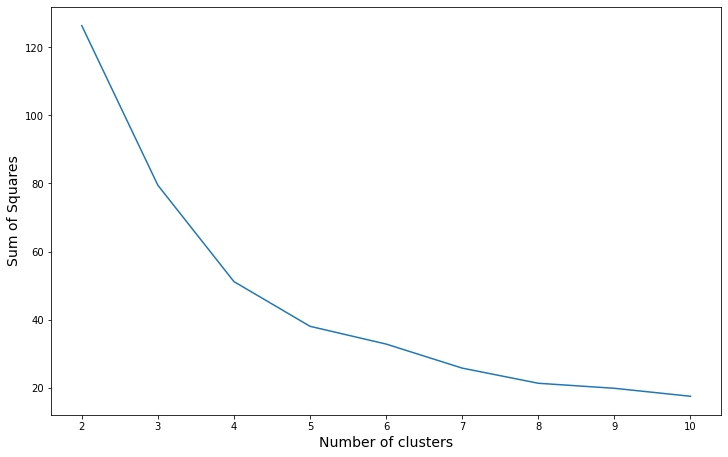

Elapsed time: 1847.6256029605865


In [7]:
start_time = time.time()

ts_kmeans_elbow(normed_angular_momentum, num_cluster=10)

print("Elapsed time:", time.time()-start_time)

In [6]:
num_cluster = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=num_cluster, metric="dtw", random_state=0, n_jobs=-1)
ts_kmeans.fit(normed_angular_momentum)

joblib.dump(ts_kmeans, 'ts_kmeans.joblib') 

['ts_kmeans.joblib']

In [4]:
ts_kmeans = joblib.load('ts_kmeans.joblib') 
cluster_labels = ts_kmeans.labels_
num_cluster = np.unique(cluster_labels).shape[0]
print(num_cluster)

5


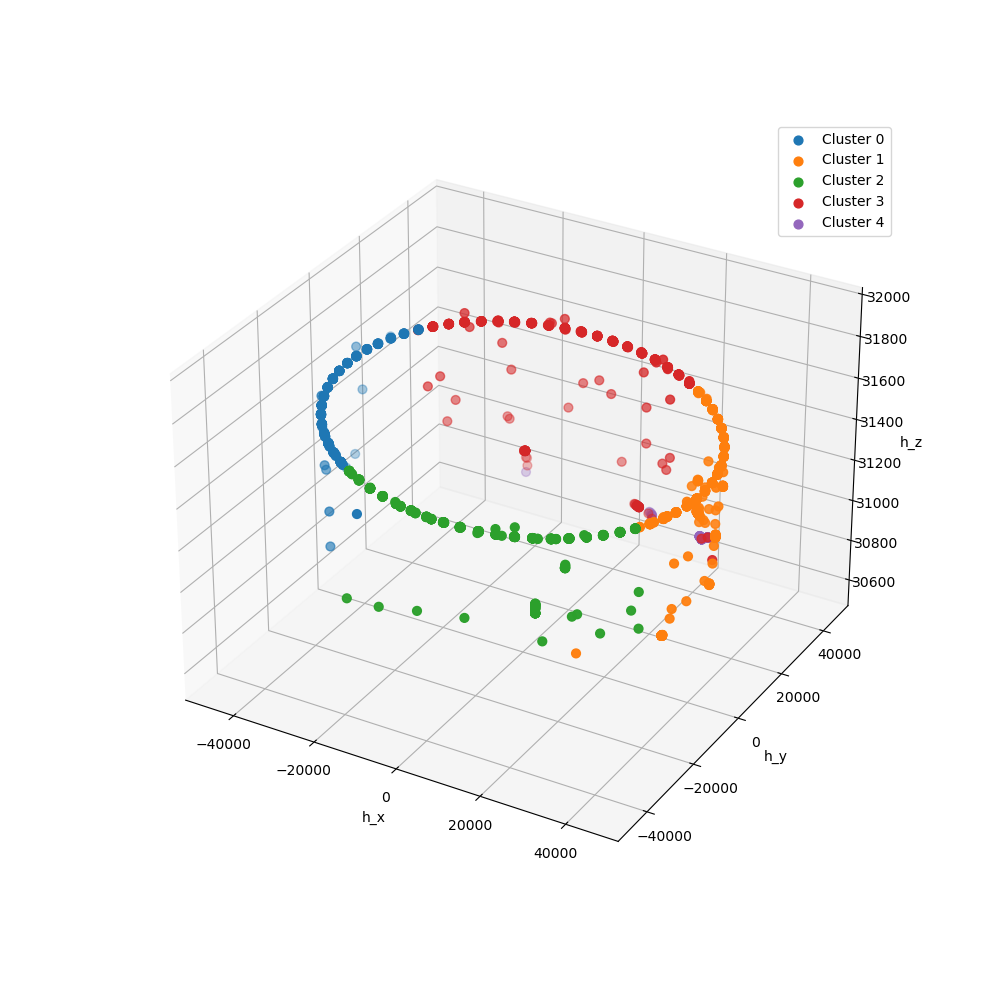

In [8]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

def plot_3d(time_point: int, 
            angular_momentum: np.ndarray, 
            cluster_labels: np.ndarray, 
            num_cluster: int):

    plt.cla()
    for i in range(num_cluster):
        ax.scatter(angular_momentum[cluster_labels == i][:, time_point, 0], 
                    angular_momentum[cluster_labels == i][:, time_point, 1], 
                    angular_momentum[cluster_labels == i][:, time_point, 2], 
                    s = 40, 
                    label = "Cluster " + str(i))

    ax.set_xlabel('h_x')
    ax.set_ylabel('h_y')
    ax.set_zlabel('h_z')
    ax.set_xlim([-50000, 50000])
    ax.set_ylim([-50000, 50000])
    ax.set_zlim([30500, 32000])
    ax.legend()

plot_3d(0, angular_momentum, cluster_labels, num_cluster)
plt.ion()
plt.show()

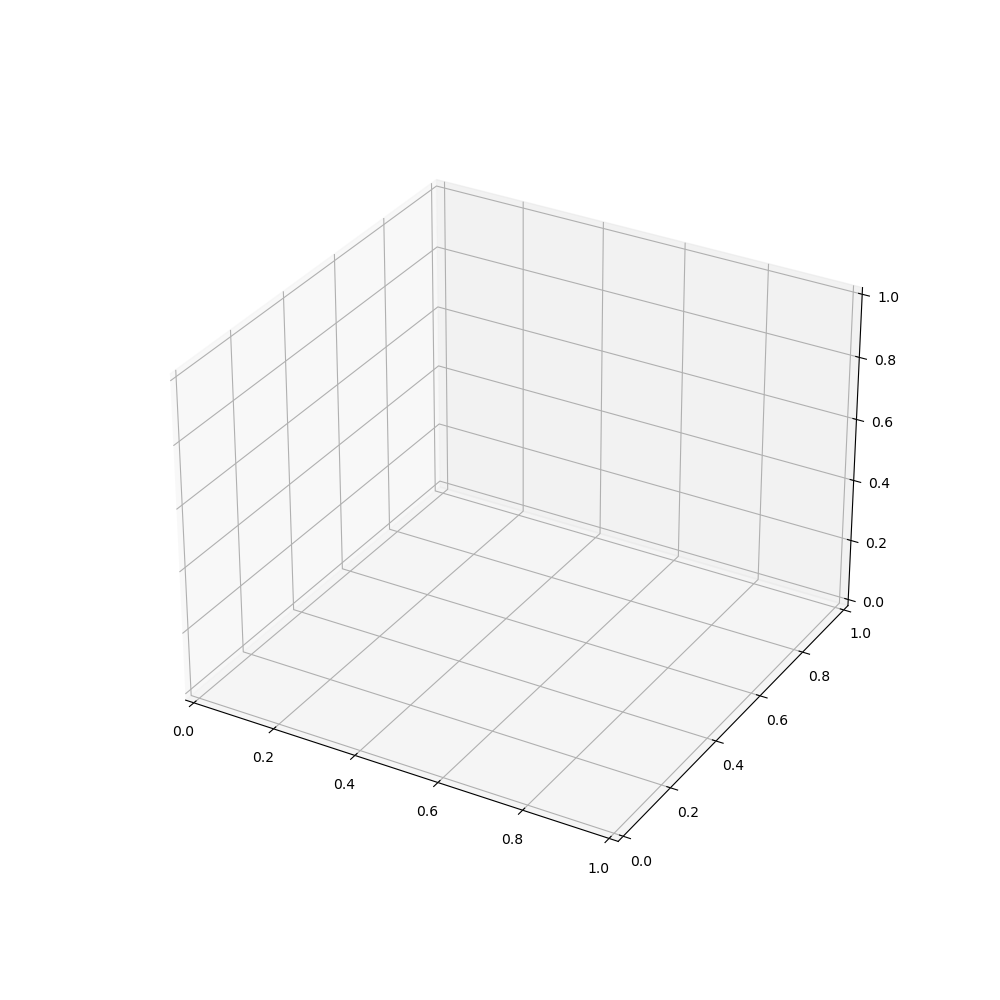

In [9]:
plt.close()

ts_fig = plt.figure(figsize = (10, 10))
ax = ts_fig.add_subplot(111, projection='3d')

anim = animation.FuncAnimation(ts_fig, 
                                plot_3d, 
                                frames=satellite_time.shape[1], 
                                interval=20, 
                                fargs=(angular_momentum, cluster_labels, num_cluster),
                                blit=True,
                                repeat_delay=200)

plt.show()